# Regridding
This notebook is an explanation for how the regrid in regrid_data.py is conducted, and the sanity checks that are available. 

Our goal is to go from the "base" noaa csl data, which is projected in Lambert Conformal Coordinates, to a lat/long (WGS) coordinate projection. The base data also has some inconsistencies, so we also standardize thinks like dimensions and attributes in the datasets. Part of the regridding process is a bit of unit conversion (to go from "absolute" units per gridcell to "flux" per m2). 

Lots of useful information was found here:       
https://medium.com/pangeo/changing-the-way-you-look-at-earth-data-with-xesmf-ee55d0b380e5          
https://fabienmaussion.info/2018/01/06/wrf-projection/     


In [12]:
#Import packages
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import sys
import cartopy.io.img_tiles as cimgt

sys.path.append('..')
import noaa_csl_funcs as ncf
from regrid_data import RegridInputs


In [2]:
#Define the day of data we want to regrid, and load it 
base_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/base' #where the data downloaded using data_download.py lives
bau_or_covid = 'COVID'
full_sector = 'area_onroad_gasoline'
year = 2019
month = 1
day_type = 'weekdy'
BCH = ncf.Base_CSL_Handler(base_path,bau_or_covid)
base_ds = BCH.load_fullday_nc(full_sector,year,month,day_type)#,chunks={'Time':1})

In [3]:
#Need to convert from "absolute" units per gridcell to "flux" units in per m^2
unit_converter = ncf.CSL_Unit_Converter() #setup the unit converter
ds_flx = unit_converter.absolute_to_flux(base_ds) #convert absolute to flux (divide by the area of the grid cell in m^2 per Colin Harkins = 4000m*4000m)
print('units = ',ds_flx['CO2'].attrs['units'])

units =  metric_Ton hr^-1 meters^-2


In [4]:
#Define inputs to the regridder
weights_path = '/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/regridding/saved_weights' #define the weights path
weights_file = 'lcc_to_latlon_onroad_gasoline_2019_1_weekdy.nc' #this can be set to 'create', and it will create the weights based on the input dataset

inputs = RegridInputs(weights_file = weights_file)#Define the inputs. these are the defaults, with the addition of the weights file. 

cr = ncf.CSL_Regridder(inputs) #create the regridder class
regridded_ds = cr.regrid_ds(ds_flx) #regrid the dataset


Creating regridder


In [ ]:
# You can save the regridder's weights to a file so you don't have to create it every time
cr.save_regrid_weights(cr.regridder) #this will save it to a default name like the one above. can also input a specific name

### Sanity Checking

To check our sanity, we want to compare the data before we regridded it to after we regridded it. To do this, we need to convert to a common unit, as the before data was in LCC per gridcell, and the regridded data is in lat/lon in flux. 

In [5]:
#Load the original dataset
og_ds = BCH.load_fullday_nc(full_sector,year,month,day_type)#,chunks={'Time':1})
#og_ds

In [6]:
#Save a subset o fthe regridded data as a netcdf 
sub_regridded_ds = regridded_ds['CO2'][1,:,:]
sub_regridded_ds.to_netcdf('../regridding/grid_area/grid_out.nc')

Open a terminal in this subdir and run. This will create an nc file with grid cell area as a data variable
> cdo gridarea ./regridding/grid_area/grid_out.nc ./regridding/grid_area/grid_out_area.nc

In [7]:
#Now we should have a file with the grid area
grid_area = xr.open_dataset('../regridding/grid_area/grid_out_area.nc')
#grid_area

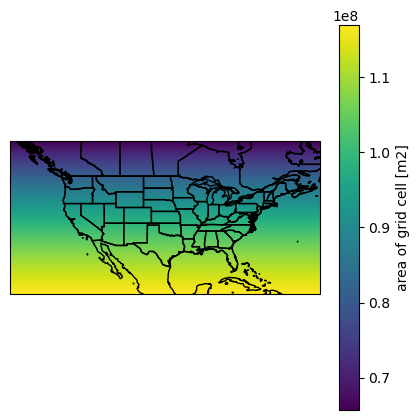

In [8]:
#Plot the grid cell area on a map -- should be less to the north and more to the south due to earth's shape
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection = proj)
grid_area['cell_area'].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

Now we can do the actual sanity check by looking at the sum of all values in the grid for a specific species both before and after regridding and compare their difference. 

In [9]:
regridded_ds_cellarea = xr.open_dataset('../regridding/grid_area/grid_out_area.nc')
perc_diff = ncf.sanity_check(og_ds,regridded_ds,regridded_ds_cellarea,'CO2')

CO2 sum diff = 0.265%


### Map
Perhaps the best sanity check is to look on a map and see if it makes sense

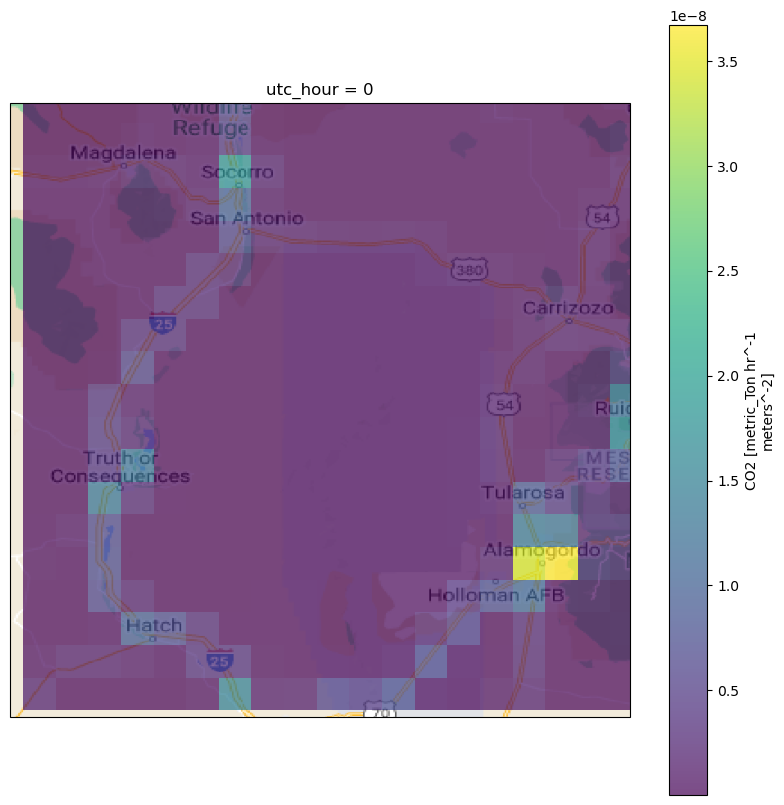

In [28]:
utc_hour = 0
species = 'CO2'

# map_extent={'lon_low':-115.4,
#             'lon_high':-109.6,
#             'lat_low':38.5,
#             'lat_high':45.0}
map_extent={'lon_low':-107.59,
            'lon_high':-105.69,
            'lat_low':32.430,
            'lat_high':34.31} 


cropped_ds = regridded_ds.sel(lat=slice(map_extent['lat_low'],map_extent['lat_high']), lon=slice(map_extent['lon_low'],map_extent['lon_high']))

labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)

#ax.set_extent([map_extent['lon_min'],map_extent['lon_max'],map_extent['lat_min'],map_extent['lat_max']],crs=proj)
request = cimgt.GoogleTiles(style='street')
scale = 8.0 # prob have to adjust this
ax.add_image(request,int(scale))

# proj = ccrs.PlateCarree()
# fig = plt.figure(figsize=(10,5))
# ax = plt.axes(projection = proj)
cropped_ds.sel({'utc_hour':utc_hour})['CO2'].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis',alpha = 0.7)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()